In [1]:
import pandas as pd
import numpy as np
import os 
from src.batch_corrector import BatchCorrector
from src.processing_helpers import *
from src.processing_pipeline import*
from sklearn.decomposition import PCA

DATA_PATH = 'data/input'

# Data processing

In [2]:

paths = [os.path.join(DATA_PATH, f) for f in ['internship_data_matrix.csv', 'internship_acquisition_list.csv']]

data_loader = DataLoader(paths)
pipeline = Pipeline()

batch_corrector = BatchCorrector()
batch_corrector.min_detection_rate = 0.7
batch_corrector.frac_loess = 0.38
batch_corrector.sample_classes = ['Dunn', 'French', 'LMU']

data_filter = PipelineStep(name='Filter batch & classes',\
                        func=lambda data, verbose: filter_types(data, {'class': ['Dunn', 'French', 'LMU', 'QC'], 'batch': [1]}, verbose=verbose))

visualizer = PipelineStep(name='PCA projection',
                          func = pca)
filters = PipelineMultiStep(name='Features filters',\
                            func=[filter_features_detection, filter_features_variability,
                                 lambda data, verbose : filter_features_dratio(data, sample_classes=['Dunn', 'French', 'LMU'], verbose=verbose)])
scaler = PipelineStep(name='StandardScaler',
                      func=normalize)
spliter = PipelineStep(name='Train-Test split',
                     func=split_train_test)


pipeline.add([data_loader, data_filter, visualizer, batch_corrector, visualizer, filters, scaler, spliter])


Loading data from files ['data/input\\internship_data_matrix.csv', 'data/input\\internship_acquisition_list.csv']
Successfully loaded 2 data files.
**************************************************************************************************** 
Running step Filter batch & classes
Successfully filtered data.
**************************************************************************************************** 
Running step PCA projection


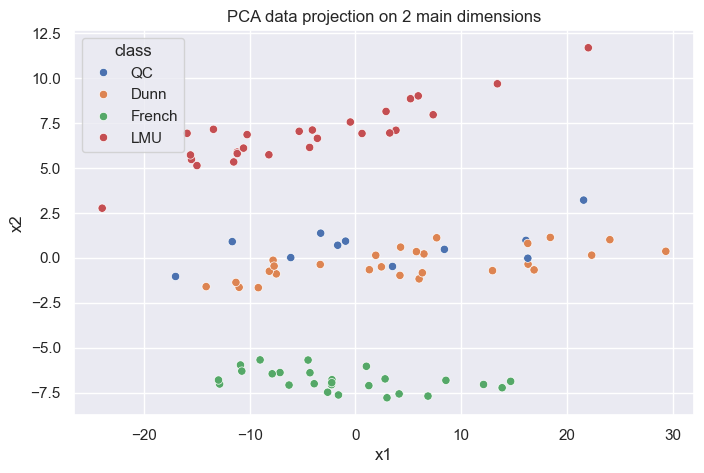

Removing 60 features:
{'FT-125', 'FT-190', 'FT-131', 'FT-086', 'FT-200', 'FT-242', 'FT-126', 'FT-201', 'FT-013', 'FT-060', 'FT-079', 'FT-072', 'FT-136', 'FT-251', 'FT-091', 'FT-116', 'FT-217', 'FT-199', 'FT-206', 'FT-246', 'FT-183', 'FT-181', 'FT-249', 'FT-153', 'FT-245', 'FT-241', 'FT-192', 'FT-225', 'FT-134', 'FT-138', 'FT-120', 'FT-115', 'FT-047', 'FT-132', 'FT-174', 'FT-238', 'FT-209', 'FT-151', 'FT-051', 'FT-188', 'FT-028', 'FT-144', 'FT-197', 'FT-172', 'FT-215', 'FT-202', 'FT-146', 'FT-148', 'FT-173', 'FT-180', 'FT-141', 'FT-177', 'FT-186', 'FT-205', 'FT-239', 'FT-071', 'FT-216', 'FT-235', 'FT-210', 'FT-243'}
Removing 0 samples:
[]
**************************************************************************************************** 
Running step PCA projection


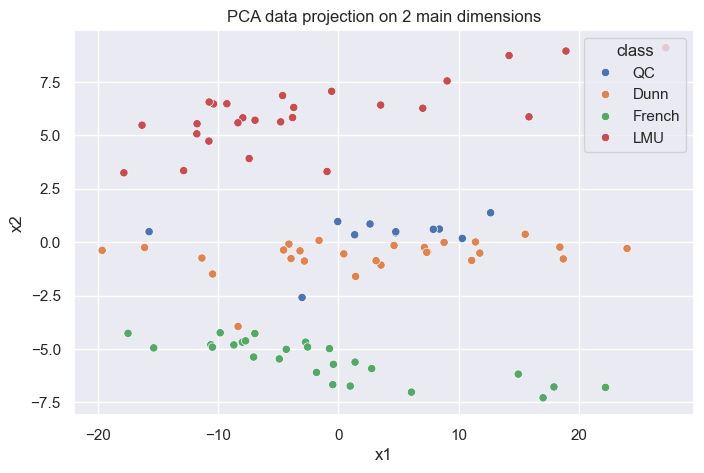

Removing 0 features              with low detection rate:
[]
Removing 17 features              with high variability :
['FT-122', 'FT-019', 'FT-128', 'FT-017', 'FT-129', 'FT-107', 'FT-121', 'FT-143', 'FT-147', 'FT-213', 'FT-109', 'FT-015', 'FT-247', 'FT-228', 'FT-029', 'FT-156', 'FT-145']
Removing 0 features               with low biological information :
[]
**************************************************************************************************** 
Running step StandardScaler
Successfully normalized data.
**************************************************************************************************** 
Running step Train-Test split
Successfully splitted train / test set.


In [3]:
x_tr, x_test, y_tr, y_test, class_map = pipeline.run(verbose=True)

# Data classification